In [35]:
import os
import re
import ast
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from nltk.tokenize import RegexpTokenizer
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

train_data = pd.read_csv(os.path.join("data", "train.csv"))
test_data = pd.read_csv(os.path.join("data", "test.csv"))
train_data.dropna(inplace=True)
X, y = train_data.drop(["price"], axis=1), train_data["price"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_test = test_data

def preprocess(df:pd.DataFrame): 
        
    def contains(x): 
        return int("shared" in str(x).lower())

    def numBath(x): 
        if "half" in x.lower(): 
            return 0.5 
        else: 
            return float(x.split()[0]) 
        
    def wordCount(x): 
        tokenizer = RegexpTokenizer(r'\w+') 
        tokens = tokenizer.tokenize(x)
        return len(tokens) 
    
    def numBedroom(x): 
        if "bedroom" not in x: 
            return 1 
        else: 
            match = re.search(r'(\d+)\s*bedroom', x)
            return int(match.group(1)) 
        
    def rating(x): 
        match_rating = re.search(r'★(\d+\.\d+)', x)
        try: 
            return float(match_rating.group(1)) if match_rating else 4.74
        except: 
            return 4.74
    
    df['host_since'] = pd.to_datetime(df['host_since'])
    df["last_scraped"] = pd.to_datetime(df['last_scraped'])
    
    df["num_days_hosted"] = (df["last_scraped"] - df['host_since']).dt.days
    
    df = df.drop(["id", "scrape_id", "last_scraped", "calendar_last_scraped", "host_since"], axis=1)
    
    df.loc[df["host_is_superhost"] == "f", "host_is_superhost"] = -1 
    df.loc[df["host_is_superhost"] == "t", "host_is_superhost"] = 1 
    df["host_is_superhost"] = df["host_is_superhost"].fillna(0) 

    for col in ["host_has_profile_pic", "host_identity_verified", "has_availability", "instant_bookable"]: 
        df.loc[df[col] == "f", col] = 0
        df.loc[df[col] == "t", col] = 1
    
    df["shared_bath"] = df["bathrooms_text"].apply(contains)
    df["num_baths"] = df["bathrooms_text"].apply(numBath)
    df = df.drop(["bathrooms_text"], axis=1)
    
    df = df.drop(["host_name"], axis=1)
    
    # one hot encode 
    dummies = df['host_verifications'].apply(lambda x: pd.Series({veri: 1 for veri in ast.literal_eval(x)}))
    dummies = dummies.fillna(0).astype(int)
    df = df.join(dummies)
    
    # dummies = df["amenities"].apply(lambda x : pd.Series({amen: 1 for amen in ast.literal_eval(x)}))
    # dummies = dummies.fillna(0).astype(int)
    # df = df.join(dummies)
    df["amenities"] = df["amenities"].apply(lambda x : len(ast.literal_eval(x))) 
    df = df.drop(["host_verifications", "amenities"], axis=1)
    
    # property_type and room_type 
    
    dummies = pd.get_dummies(df["room_type"])
    df = df.join(dummies) 
    df = df.drop(["property_type", "room_type"], axis=1)
    
    # Take 'name' and extract 'num_bedroom' (default=1) and 'rating' (default=mean(ratings))
    df["num_bedroom"] = df["name"].apply(numBedroom)
    df["rating"] = df["name"].apply(rating)
    
    # Take 'description' and extract the number of adjectives as a measure of "flashiness" of description
    df["description"] = df["description"].apply(wordCount)
    
    # image 
    df = df.drop(["picture_url", "name", "neighbourhood_cleansed", "neighbourhood_group_cleansed"], axis=1)
    
    df = df.to_numpy().astype(float)
    
    # scale this to [0, 1]
    scaler = StandardScaler()
    scaler.fit(df)
    df = scaler.transform(df)
    
    return torch.tensor(df, dtype=torch.float32)



class AirBnbDataset(Dataset): 
    
    def __init__(self, X, y): 
        
        self.X = preprocess(X)   
        self.y = y.to_numpy().astype(int)
        self.num_features = self.X.shape[1]
        
    
    def __len__(self): 
        return self.X.shape[0] 
    
    def __getitem__(self, i): 
        return (self.X[i, :], self.y[i])

        
device = "cuda" if torch.cuda.is_available() else "cpu"

In [36]:
trainset = AirBnbDataset(X_train, y_train) 
valset = AirBnbDataset(X_val, y_val)

trainloader = DataLoader(trainset,    # our dataset
                              batch_size=512,    # batch size
                              shuffle=True      # shuffling the data
                            )
valloader = DataLoader(valset, batch_size=512, shuffle=True)

In [37]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def oneHot(y): 
    one_hot = torch.zeros(len(y), 6)
    for idx, class_num in enumerate(y):
        one_hot[idx, class_num] = 1 
    return one_hot

def train(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, oneHot(y).to(device))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return loss 
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, oneHot(y).to(device)).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss 

In [46]:
model = NeuralNetwork(trainset.num_features).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),     # which parameters to optimize
    lr=1e-2,                 # learning rate 
    momentum=0.9
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epochs = 50
train_losses, val_losses = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(trainloader, model, loss_fn, optimizer, scheduler))
    val_losses.append(test(valloader, model, loss_fn))
    # scheduler.step() 
    # print(f"lr : {optimizer.lr}")
print("Done!")

Epoch 1
-------------------------------
loss: 1.785688  [  512/11740]
Test Error: 
 Accuracy: 32.2%, Avg loss: 1.592517 

Epoch 2
-------------------------------
loss: 1.568891  [  512/11740]
Test Error: 
 Accuracy: 42.6%, Avg loss: 1.448041 

Epoch 3
-------------------------------
loss: 1.455566  [  512/11740]
Test Error: 
 Accuracy: 45.6%, Avg loss: 1.357717 

Epoch 4
-------------------------------
loss: 1.356185  [  512/11740]
Test Error: 
 Accuracy: 46.7%, Avg loss: 1.317556 

Epoch 5
-------------------------------
loss: 1.310841  [  512/11740]
Test Error: 
 Accuracy: 47.7%, Avg loss: 1.289433 

Epoch 6
-------------------------------
loss: 1.332014  [  512/11740]
Test Error: 
 Accuracy: 48.9%, Avg loss: 1.271268 

Epoch 7
-------------------------------
loss: 1.275103  [  512/11740]
Test Error: 
 Accuracy: 49.1%, Avg loss: 1.258869 

Epoch 8
-------------------------------
loss: 1.245606  [  512/11740]
Test Error: 
 Accuracy: 49.3%, Avg loss: 1.242643 

Epoch 9
----------------

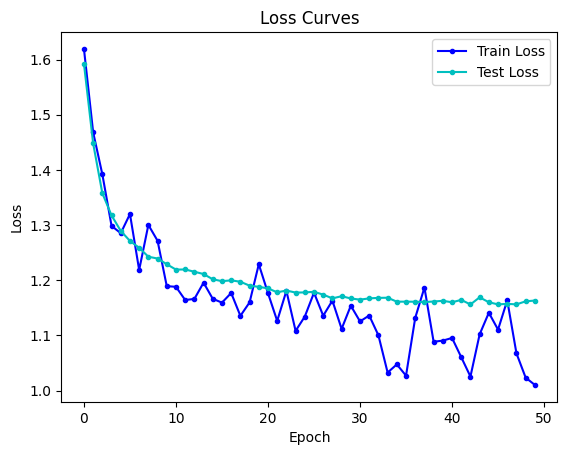

In [47]:
import matplotlib.pyplot as plt 

plt.plot([x.item() for x in train_losses], c="b", marker=".", label="Train Loss")
plt.plot(val_losses, c="c", marker=".", label="Test Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show() 

In [6]:
test_predictions = model(preprocess(X_test).to(device)).argmax(1)
submission = {
    "id" : list(range(len(test_predictions.cpu().numpy()))), 
    "price" : list(test_predictions.cpu().numpy().astype(float))
}

submission = pd.DataFrame.from_dict(submission)

submission.to_csv("bahng_n.csv", index=False)